# PharmSci 175/275 (UCI)
## What is this?? 
The material below is a supplement to the quantum mechanics (QM) lecture from Drug Discovery Computing Techniques, PharmSci 175/275 at UC Irvine. 
Extensive materials for this course, as well as extensive background and related materials, are available on the course GitHub repository: [github.com/mobleylab/drug-computing](https://github.com/mobleylab/drug-computing)

# Using QM in Python

This material adapted (under CC-BY) from a [workshop example](https://github.com/QCMM/workshop2017/blob/master/Theory_electronic_structure_day3/i_inter_es.ipynb) of Stefano Vogt-Giesse (University of Concepcion) from the December, 2017 QCMM workshop in Chile, available under the [workshop repository](https://github.com/QCMM/workshop2017)

### Instructor: David L. Mobley

### Contributors to these materials:
- Stefano Vogt-Giesse
- David L. Mobley

## Choose whether to run under Google Colab or locally

You need to do different preparation to run this notebook locally vs Google Colab; skip to the appropriate section following depending on which you choose.

## Preparation for using Google Colab (SKIP IF RUNNING LOCALLY))

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MobleyLab/drug-computing/blob/master/uci-pharmsci/lectures/QM/psi4_example.ipynb)

If you are running this on Google Colab, you need to take a couple additional steps of preparation. **Note that these steps may take 5-10 minutes to complete.**

Psi4 installs via `conda`, not pip, so you will need to get conda set up on Colab: 

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.10.3-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.10.3-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

Then `conda`-install psi4:

In [ ]:
!conda install -c psi4 psi4 --yes

## Preparation for running locally (SKIP IF RUNNING USING COLAB)

For today's activity we will use the package of program psi4, so we will need to install it first. Assuming you already have anaconda/miniconda installed, you can install as follows (in a new conda environment, `p4env`:


**conda create -n psi4 psi4 psi4-rt jupyter matplotlib -c psi4/label/dev -c psi4**

(Note psi4 seems to be somewhat incompatible with the other software we are using in this course, so a separate environment is needed.)

This will install all the psi4 binaries and a python module which can be imported from the notebook. Then activate the environment via `conda activate psi4`.

You also need to ensure it works in your jupyter notebook, which you can do via (in the terminal, with your `psi4` environment active):
```
conda install ipykernel --name psi4
python -m ipykernel install --user
```

To finish the installation you need to provide a scratch directory in your `~/.bash_profile`, for example (assuming you want your scratch directory in this space):

**export PSI_SCRATCH=/home/user_name/scratch/psi4**

Then type `source ~/.bash_profile`. Now you may open jupyter-notebook and install psi4.

Every time you wish to use psi4 you will need to `conda activate psi4`.

# Exploring molecular interactions using electronic structure methods.

In [ ]:
import psi4 
import numpy as np

# 1. Compute the energy of a diatomic molecule


As a first example we will compute the scf energy of the diatómic molecule hydrogen flouride (HF):


In [2]:
# ==> Basic Psi4 options <==
# Memory
psi4.set_memory(int(5e8))
numpy_memory = 500

# Output
psi4.core.set_output_file('output.dat', False)

# Geometry input
hf_mol = psi4.geometry("""
0 1
H
F 1 0.917
""")

energy_hf_mol , wfn_hf_mol = psi4.energy('mp2/cc-pvtz', return_wfn=True)
print(energy_hf_mol) #Energy in Hartrees

-100.3429063303609


This corresponds to the MP2/cc-pVTZ energy for this system (HF).  Input coordinates are given in [Z matrix format](https://en.wikipedia.org/wiki/Z-matrix_(chemistry)), using internal coordinates (in this case just a bond distance).


### Exercise: Compute the energy of other diatomic molecules using similar methods
You might consider computing the energy of of F$_2$ and N$_2$ using the cc-pVDZ and cc-pVTZ methods. 

# 2. Compute the dipole and quadrupole moment of diatomic molecules

Since we are intrested in studying long range  molecular interactions using classical elctrodynamics, it is necessary 
to compute the dipole and quadrupole moments. Quantum mechanically the dipole can be computed using the one electron dipole operator:

\begin{equation}
\hat{\mu} = \sum_i q_i r_i 
\end{equation}

where $q_i$ is the charge of the particle and $r_i$ is the position vector of the particle.  The dipole moment can be computed using the wavefunction through the expectation value of the operator $\mu$.

\begin{equation}
\mu = <\psi|\hat{\mu}|\psi> 
\end{equation}

In psi4 we can obtain the dipole moment from the wafefunction object that was defined above

In [3]:
psi4.oeprop(wfn_hf_mol, 'DIPOLE', 'QUADRUPOLE', title='HF SCF')

mux = psi4.core.get_variable('HF SCF DIPOLE X') # in debye
muy = psi4.core.get_variable('HF SCF DIPOLE Y')
muz = psi4.core.get_variable('HF SCF DIPOLE Z')
quad_zz = psi4.core.get_variable('HF SCF QUADRUPOLE ZZ')

In [4]:
print(muz)
print(quad_zz)
mu = (np.sqrt(mux**2 + muy**2 + muz**2))
print(mu)

-1.9411548174366635
-3.271015995238057
1.94115481744


# 3.  Compute a potential energy surface of HF dimer.

In order to study the physical interactions between two molecules it is convinient to draw 
a potential energy surface along the interaction coordinate. In this section we will 
obtain a potential energy profile for the most favorable dipole-dipole interaction, which is the 
horizontal orientation with oposing dipole vectors, HF---FH. First we need to define a list containing 
the distances between both dimers for which the energy will be obtained.

In [5]:
hf_dimer = psi4.geometry("""
        0 1
        H
        F 1 0.917
        H 2 R 1 180.0
        F 3 0.917 2 180.0 1 0.0
        """)

Next, we write a loop and in each step of the loop we compute the energy at the mp4 level of theory. 

In [6]:
energy = []
dist   = []

Rval = np.arange(1.5,10.0,0.1)

for d in Rval:
    hf_dimer.R = d
    psi4.set_options({'freeze_core': 'True'})
    en = psi4.energy('scf/cc-pvtz')
    print(en)
    print(d)
    energy.append(en)
    dist.append(d)


-200.1159400762018
1.5
-200.1190819646694
1.6
-200.12084511069853
1.7
-200.1217418230204
1.8
-200.12210646265714
1.9
-200.12214740628218
2.0
-200.12199128622555
2.1
-200.12171855348862
2.2
-200.1213834825437
2.3
-200.12102248398264
2.4
-200.1206584434578
2.5
-200.12030471830317
2.6
-200.11996870223288
2.7
-200.11965427034008
2.8
-200.11936321363657
2.9
-200.11909600295286
3.0
-200.1188522860765
3.1
-200.11863115701004
3.2
-200.11843131717893
3.3
-200.11825114501002
3.4
-200.11808882589855
3.5
-200.11794245507383
3.6
-200.11781018000022
3.7
-200.11769030206548
3.8
-200.11758132579342
3.9
-200.11748198075108
4.0
-200.11739119292795
4.1
-200.11730805328622
4.2
-200.11723176731104
4.3
-200.11716164900196
4.4
-200.11709708263894
4.5
-200.1170375095619
4.6
-200.1169824408411
4.7
-200.11693143092367
4.8
-200.11688408496144
4.9
-200.11684005298991
5.0
-200.1167990260822
5.1
-200.1167607297471
5.2
-200.11672492543434
5.3
-200.11669140001007
5.4
-200.1166599601226
5.5
-200.11663044555814
5.6
-20

Now we are ready to plot the potential energy profile. We will use the matplotlib python library for this 
purpose. The function `ref_zero_kcal` transforms the energy which is in Hartee to kcal/mol and takes the 
energy of the dimer with the farthest separation as the reference energy.

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0,0.5,'Energy (kcal/mol)')

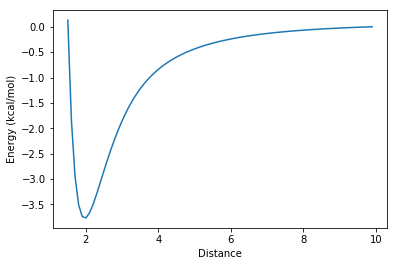

In [13]:
def ref_zero_kcal(en_list):
    energy_kcal = []
    for x in range(len(en_list)):
        energy_kcal.append((en_list[x] - en_list[-1])*627.51)
    return energy_kcal


energy_kcal = ref_zero_kcal(energy)    
plt.plot(dist,energy_kcal)
plt.xlabel('Distance')
plt.ylabel('Energy (kcal/mol)')

There are many more examples/tutorials in the Psi4 GitHub repositories, especially see `Tutorials` under the (psi4numpy repository](https://github.com/psi4/psi4numpy) for many Jupyter notebooks.